# MCMC to fit atmospheric parameters on measured air transmission

https://github.com/DifferentiableUniverseInitiative/jax-cosmo-paper/blob/master/notebooks/VectorizedNumPyro.ipynb

In [1]:
from diffatmemulator.diffatmemulator import DiffAtmEmulator
from diffatmemulator.diffatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [2]:
from instrument.instrument import Hologram

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
jax.config.update("jax_enable_x64", True)

import numpyro
from numpyro import optim
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, HMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoBNAFNormal, AutoMultivariateNormal
from numpyro.infer.reparam import NeuTraReparam
from numpyro.handlers import seed, trace, condition

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 15
mpl.rcParams["figure.figsize"] = [8, 8]

In [4]:
import os
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

In [5]:
def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None,
                   var_names=None, point_estimate="median"):
    
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            figsize=(10,10),
            kind="kde",
    #        marginal_kwargs={"plot_kwargs": {"lw": 3, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":3},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 3, "c": "b"},
            marginals=True, textsize=20, point_estimate=point_estimate,
        );
    
    plt.tight_layout()
    
    if patName is not None:
        patName_patch = mpatches.Patch(color='b', label=patName)
        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
    if fname is not None:
        plt.savefig(fname)
        plt.close()

# Instrument

defines the properties of the instrument measurement. The detector consists in the CCD plate of the Auxtel telescope. The Hologram class allows to retrieve the correct wavelength sampling corresponding to the measurement of a spectrum. This wavelength sampling correspond to pixel size sampling.

In [6]:
h = Hologram(rebin=1)

In [7]:
wls = h.get_wavelength_sample()

## Emulator

In [8]:
obs_str = "LSST"

emul1 =  DiffAtmEmulator(obs_str=obs_str)
emul2 =  DiffAtmEmulator(obs_str=obs_str,pressure=800.)

In [9]:
P1 = emul1.pressure
P2 = emul2.pressure

In [10]:
transm1 = emul1.vect1d_Alltransparencies(wls,am=1,pwv=4.0,oz=400.,tau=0.1,beta=-1.2)
transm2 = emul2.vect1d_Alltransparencies(wls,am=1,pwv=4.0,oz=400.,tau=0.1,beta=-1.2)

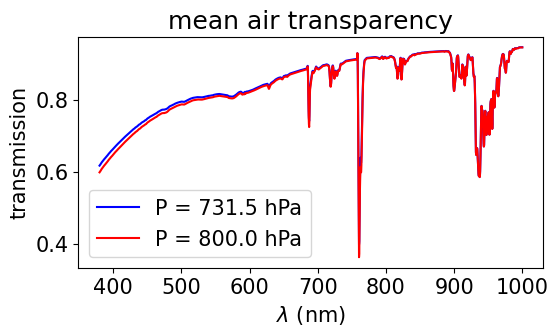

In [11]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(wls,transm1,'b',label=f"P = {P1:.1f} hPa")
ax.plot(wls,transm2,'r',label=f"P = {P2:.1f} hPa")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("mean air transparency")
ax.legend()

In [12]:
def mean_transm(x, params,airmass):
    """ mean function of the model of transmission 
    :param x: set of wavelengths measured experimentaly (independent variable)  
    :type x: float, in unit nm
    
    :param params: dictionnary of parameters to be fitted
    :type params: float
    ...
    :raises [ErrorType]: [ErrorDescription]
    ...
    :return: return the transmission
    :rtype: float

    Assume the airmass is set to 1.0
    
    """
    pressure = params["P"]
    pwv  = params["pwv"]
    oz = params["oz"]
    tau =  params["tau"]
    beta =  params["beta"]

    airmass = airmass
    wls = x

    emul = DiffAtmEmulator(obs_str=obs_str,pressure=pressure)
    transm= emul.vect1d_Alltransparencies(wls,am=airmass,pwv=pwv,
                                          oz=oz,tau=tau,beta=beta)
    
    return transm

In [13]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [14]:
sigma_obs=0.01 # 5 mmag accuracy

In [15]:
airmass = 1.0
par_true={"P":730.0, "pwv":4.0, "oz":400, "tau": 0.05, "beta": -1.2}

In [16]:
TMes = mean_transm(wls,par_true,airmass) + sigma_obs * jax.random.normal(rng_key1,shape=wls.shape)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


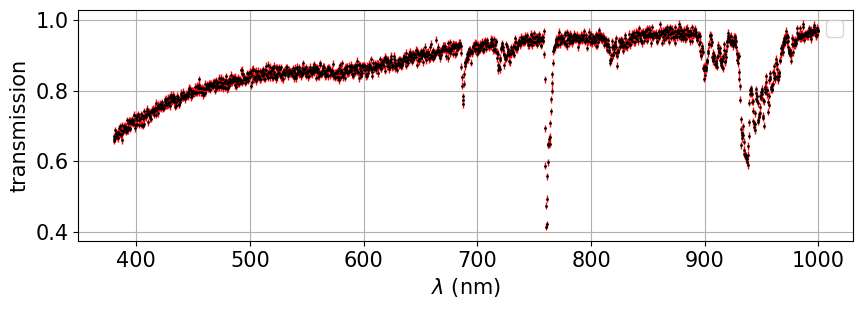

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.errorbar(wls,TMes,yerr=sigma_obs,fmt="o",ms=1,color="k",ecolor="r",lw=1)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.legend()
ax.grid();

In [18]:
def model(wls,Tobs=None,
          P_min=700.,pwv_min = 0.,oz_min = 0., tau_min=0.,beta_min=-3,
          P_max=800.,pwv_max = 10.,oz_max = 550., tau_max=0.5,beta_max=0,
          airmass=1,sigma= 0.01):
    
    # priors
    pressure = numpyro.sample("P", dist.Uniform(P_min,P_max))
    pwv  = numpyro.sample("pwv", dist.Uniform(pwv_min,pwv_max))
    oz  = numpyro.sample("oz", dist.Uniform(oz_min,oz_max))
    tau= numpyro.sample("tau", dist.Uniform(tau_min,tau_max))
    beta= numpyro.sample("beta", dist.Uniform(beta_min,beta_max))
    
    params = {"P":pressure, "pwv":pwv, "oz":oz, "tau":tau, "beta":beta}
    mu = mean_transm(wls,params,airmass)
    
    with numpyro.plate("obs", wls.shape[0]):  # les observables sont indépendantes
        numpyro.sample('T', dist.Normal(mu, sigma), obs=Tobs)


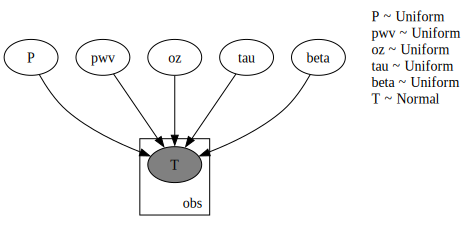

In [19]:
numpyro.render_model(model, model_args=(jnp.array([0.]),jnp.array([1.])),render_distributions=True)

In [20]:
from numpyro.handlers import seed, trace, condition
# So, let's generate the data at the fiducial parameters
fiducial_model = condition(model, par_true)
# Run the conditionned model (if not conditionned the priors are executed)
trace_data = trace(seed(fiducial_model, jax.random.PRNGKey(42))).get_trace(wls, sigma=sigma_obs)

In [21]:
#trace_data

In [22]:
TMes_bis = trace_data['T']["value"]

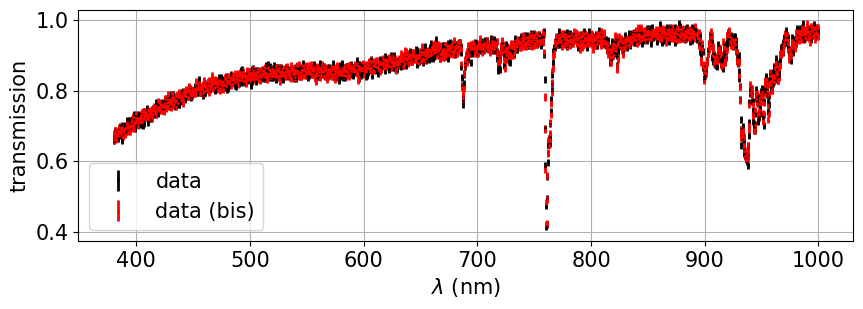

In [23]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.errorbar(wls,TMes,yerr=sigma_obs,fmt='o',ms=1. ,linewidth=2, capsize=0, c='k', label="data")
ax.errorbar(wls,TMes_bis,yerr=sigma_obs, fmt='o', ms=1.,linewidth=2, capsize=0, c='r', label="data (bis)")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.legend()
ax.grid();

In [24]:
# Run NUTS.
kernel = NUTS(model, dense_mass=True, target_accept_prob=0.9,
              init_strategy=numpyro.infer.init_to_median())
num_samples = 5_000
n_chains = 4
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,
            chain_method='vectorized',
            progress_bar=True)
mcmc.run(rng_key, wls=wls, Tobs=TMes,sigma=sigma_obs,extra_fields=('potential_energy',))
#mcmc.run(rng_key, wls=wls, Tobs=TMes,sigma=sigma_obs)
mcmc.print_summary()
samples_nuts = mcmc.get_samples()

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [03:37<00:00, 27.57it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         P    727.92      5.23    727.94    719.82    736.92  21095.81      1.00
      beta     -1.22      0.04     -1.22     -1.28     -1.16  23603.62      1.00
        oz    403.93      7.60    403.87    391.55    416.40  26226.61      1.00
       pwv      3.99      0.03      3.99      3.94      4.04  29788.87      1.00
       tau      0.05      0.00      0.05      0.05      0.05  22580.43      1.00

Number of divergences: 0


In [25]:
az.ess(samples_nuts, relative=True)  # efficacité relative

<xarray.Dataset>
Dimensions:  ()
Data variables:
    P        float64 1.05
    beta     float64 1.182
    oz       float64 1.311
    pwv      float64 1.47
    tau      float64 1.129

/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


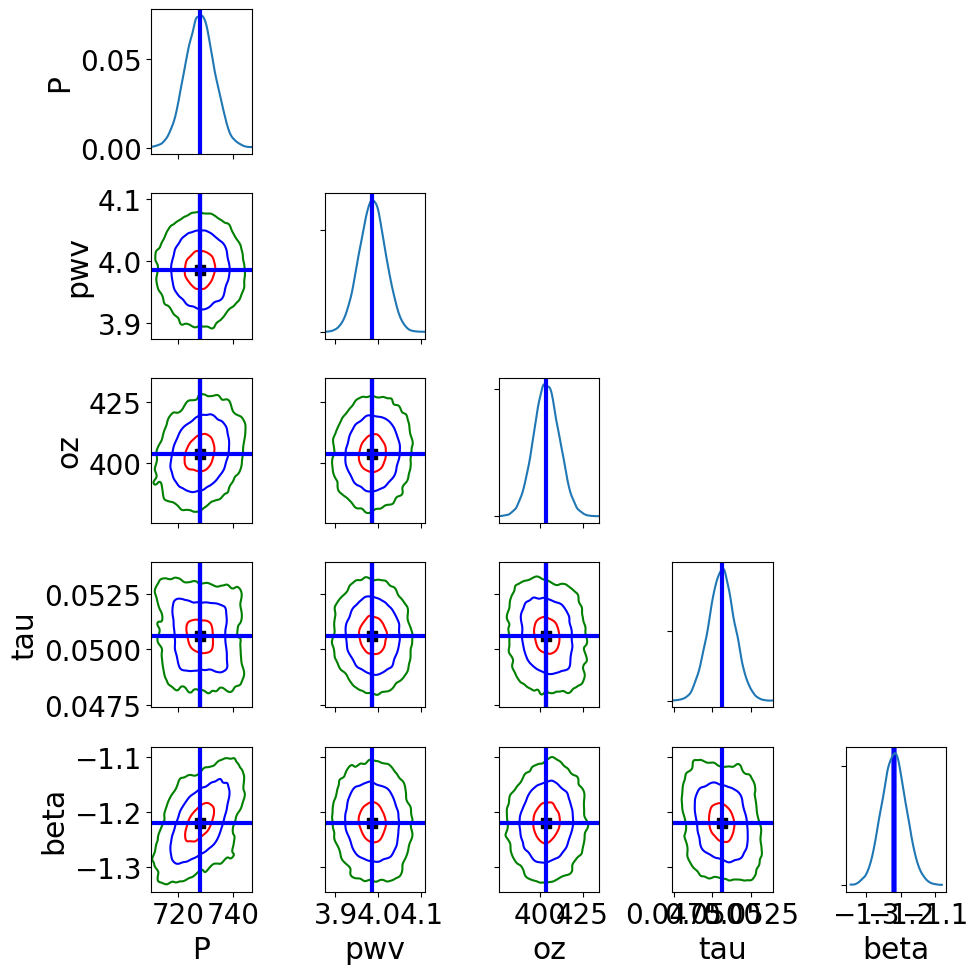

In [26]:
plot_params_kde(samples_nuts, pcut=[0.001,99.999], var_names=['P', 'pwv','oz', 'tau','beta'])

In [27]:
wls_val = np.linspace(300.,1000,100)

In [28]:
Ttrue_val = mean_transm(wls_val,par_true,airmass)

In [29]:
func = jax.vmap(lambda x: mean_transm(wls_val,x,airmass))

In [30]:
Tall_val= func(samples_nuts) 

In [31]:
Tmean_val = jnp.mean(Tall_val,axis=0)

In [32]:
std_T_val = jnp.std(Tall_val,axis=0)

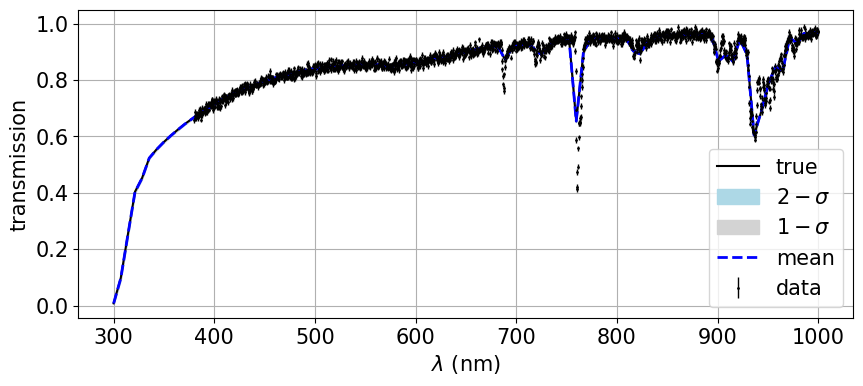

In [33]:
fig,ax =plt.subplots(1,1,figsize=(10,4))
ax.errorbar(wls,TMes,yerr=sigma_obs,fmt='o', ms=1,linewidth=1, capsize=0, c='k', label="data")
ax.plot(wls_val,Ttrue_val,c='k',label="true")

ax.fill_between(wls_val, Tmean_val-2*std_T_val, Tmean_val+2*std_T_val, 
                    color="lightblue",label=r"$2-\sigma$")
ax.fill_between(wls_val, Tmean_val-std_T_val, Tmean_val+std_T_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
ax.plot(wls_val, Tmean_val, "blue", ls="--", lw=2.0, label="mean")


ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.legend()
ax.grid();

In [34]:
samples_nuts

{'P': Array([735.60250871, 735.03208245, 725.85629749, ..., 733.73858398,
        734.05446765, 721.53019596], dtype=float64),
 'beta': Array([-1.23065185, -1.22527309, -1.23947019, ..., -1.18528573,
        -1.19245586, -1.23385206], dtype=float64),
 'oz': Array([408.6251799 , 411.05870407, 403.25059495, ..., 406.399711  ,
        410.75758645, 400.06497585], dtype=float64),
 'pwv': Array([3.98886555, 3.98505189, 4.01517254, ..., 3.94192034, 3.95201935,
        4.02144949], dtype=float64),
 'tau': Array([0.04893653, 0.04983475, 0.05081992, ..., 0.04982258, 0.05011446,
        0.05100243], dtype=float64)}

In [35]:
data = samples_nuts

In [36]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map={"P": r"$P$", 
                                         "pwv":r"$H_2O$",
                                         "oz":r"$O_3$",
                                         "tau":r"$\tau$",
                                         "beta":r"$\beta$" 
                                        })


/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


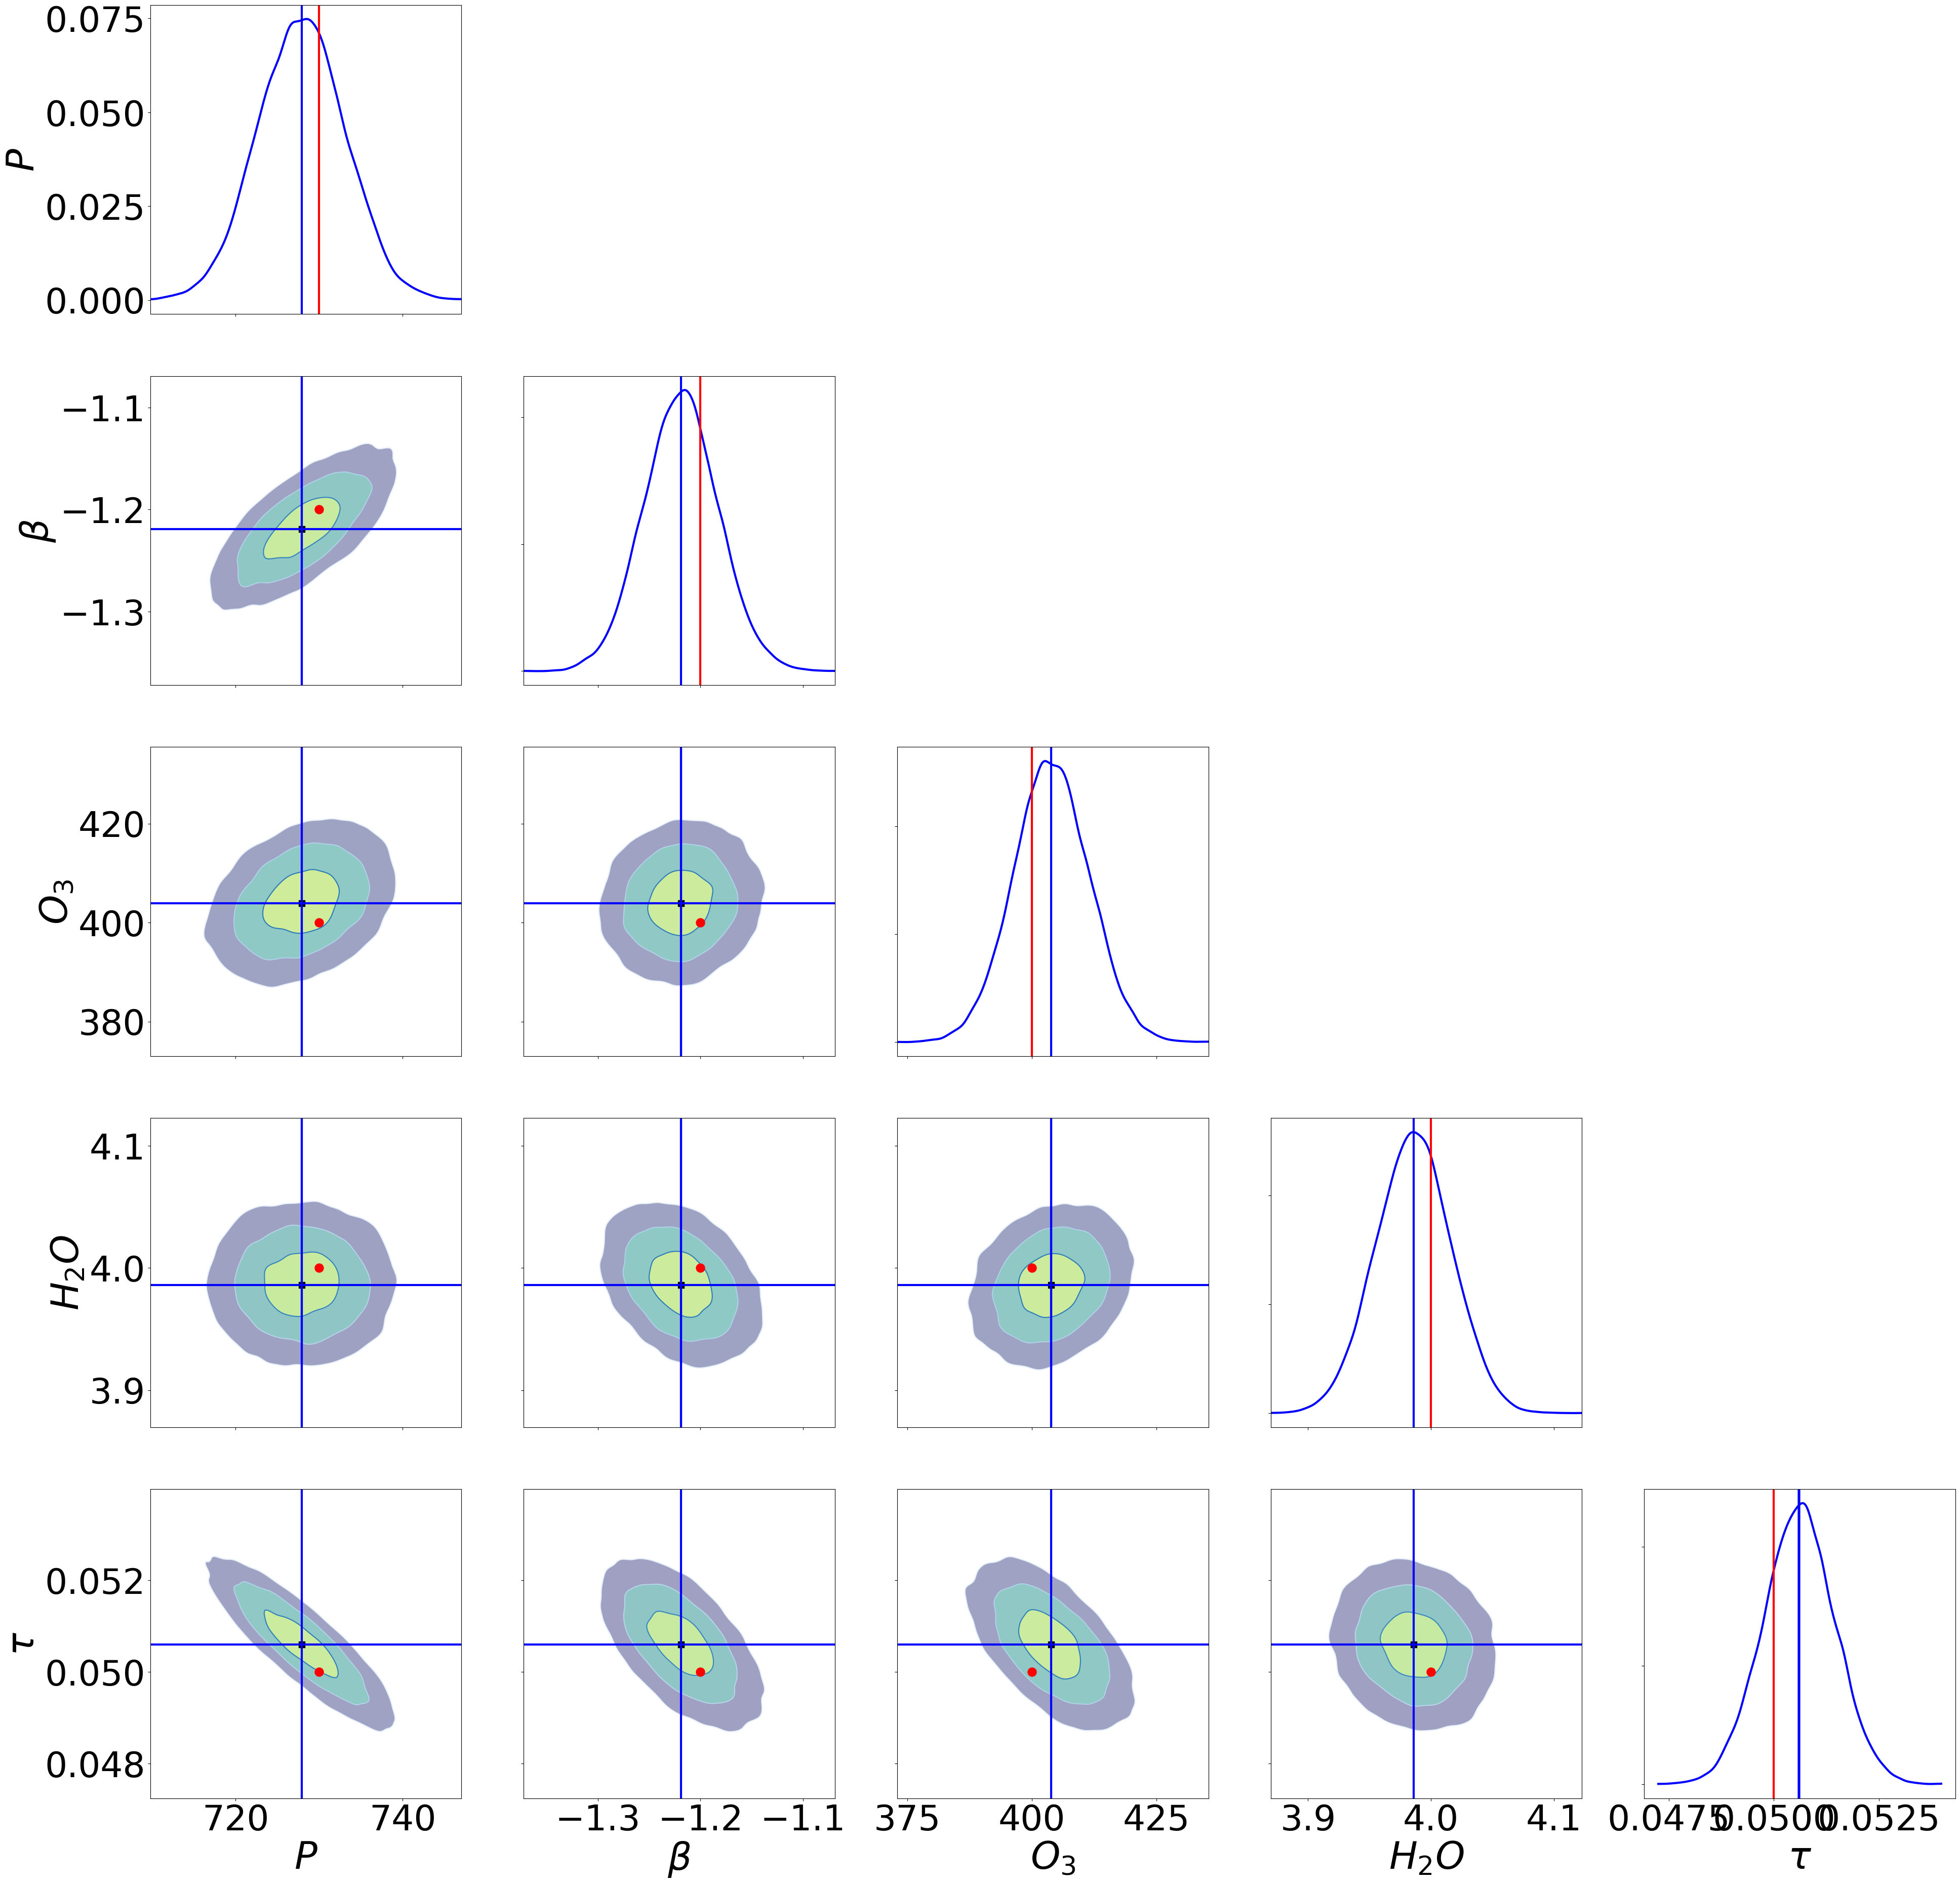

In [37]:
ax=az.plot_pair(
        data,
        kind="kde",
        labeller=labeller,
        marginal_kwargs={"plot_kwargs": {"lw":3, "c":"blue", "ls":"-"}},
        kde_kwargs={
            "hdi_probs": [0.3, 0.68, 0.9],  # Plot 30%, 68% and 90% HDI contours
            "contour_kwargs":{"colors":None, "cmap":"Blues", "linewidths":3,
                              "linestyles":"-"},
            "contourf_kwargs":{"alpha":0.5},
        },
        point_estimate_kwargs={"lw": 3, "c": "b"},
        marginals=True, textsize=50, point_estimate='median',
    );

ax[1,0].scatter(par_true["P"],par_true["beta"],c="r",s=150,zorder=10)
ax[2,0].scatter(par_true["P"],par_true["oz"],c="r",s=150,zorder=10)
ax[2,1].scatter(par_true["beta"],par_true["oz"],c="r",s=150,zorder=10)
ax[3,0].scatter(par_true["P"],par_true["pwv"],c="r",s=150,zorder=10)
ax[3,1].scatter(par_true["beta"],par_true["pwv"],c="r",s=150,zorder=10)
ax[3,2].scatter(par_true["oz"],par_true["pwv"],c="r",s=150,zorder=10)
ax[4,0].scatter(par_true["P"],par_true["tau"],c="r",s=150,zorder=10)
ax[4,1].scatter(par_true["beta"],par_true["tau"],c="r",s=150,zorder=10)
ax[4,2].scatter(par_true["oz"],par_true["tau"],c="r",s=150,zorder=10)
ax[4,3].scatter(par_true["pwv"],par_true["tau"],c="r",s=150,zorder=10)

ax[0,0].axvline(par_true['P'],c='r',lw=3)
ax[1,1].axvline(par_true['beta'],c='r',lw=3)
ax[2,2].axvline(par_true['oz'],c='r',lw=3)
ax[3,3].axvline(par_true['pwv'],c='r',lw=3)
ax[4,4].axvline(par_true['tau'],c='r',lw=3)